<a href="https://colab.research.google.com/github/Karimsingera/CODERHOUSE-PYTHON-/blob/main/Proyecto_final_Python_(Karim_Singer).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJETO FINAL.
CURSO DE PYTHON #54355
ALUNO: KARIM SINGER

**Revisão histórica de dados meteorológicos de 3 cidades do Brasil. Uruçuca,
Rio de Janeiro, Brasília (1950-2023)**

Neste projeto trabalhamos com o banco de dados **'Open-Meteo'**, uma API gratuita para consultas de diversos dados meteorológicos.

**BIBLIOTECAS**

In [1]:
'''
instalação das bibliotecas necessárias.
'''

!pip install openmeteo-requests
!pip install requests-cache retry-requests
!pip install plyer

In [2]:
'''
importando bibliotecas
'''

import openmeteo_requests
import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry
import matplotlib.pyplot as plt
import sqlite3
import csv
import plyer
from plyer import notification
import datetime

**ALERTA**

In [3]:
def alerta(nivel, base, etapa, erro=""):
    '''
        Alerta de falha de carregamento de base de dados
    '''
    now = str(datetime.now())

    msg = f"Falha no carregamento da base {base} na etapa {etapa}.\n{now}\n{erro}"


    if nivel == 1:
        title = 'ATENÇÃO: Alerta Baixo'
    elif nivel == 2:
        title = 'ATENÇÃO: Alerta Médio'
    elif nivel  == 3:
        title = 'ATENÇÃO: Alerta Alto'
    else:
        print("Nivel",nivel,"não disponível!")

    notification.notify(
            title=title,
            message=msg,
            app_name='alerta',
            timeout=10
        )

**CONSULTAS À API 'OPEN-METEO'**

Primeira consulta:
Seleção de dados meteorológicos (1950-2024)

As consultas são baseadas em dados georreferenciais da cidade de **Uruçuca, Bahia**.

Coordenadas geográficas de Uruçuca
Uruçuca está localizada na latitude -14,59306 e longitude -39,28444. Faz parte do continente da América do Sul e está localizado no hemisfério sul.

https://www.geodatos.net/coordenadas/brasil/urucuca

A estrutura de consulta abaixo é feita a partir da documentação da API em:

https://open-meteo.com/en/docs/historical-weather-api

In [4]:
#Dados Uruçuca:

uruçuca_lat = '-14.5931'
uruçuca_log = '-39.2844'



# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [uruçuca_lat],
	"longitude": [uruçuca_log],
	"start_date": "1950-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "precipitation_sum"],
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(2).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(3).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["precipitation_sum"] = daily_precipitation_sum

# nomeie o DataFrame e imprima-o
uruçuca_df = pd.DataFrame(data = daily_data)
print(uruçuca_df)


Coordinates -14.586994171142578°E -39.2757568359375°N
Elevation 86.0 m asl
Timezone b'America/Sao_Paulo' b'-03'
Timezone difference to GMT+0 -10800 s
                     date  temperature_2m_max  temperature_2m_min  \
0     1950-01-01 03:00:00           29.710001           21.460001   
1     1950-01-02 03:00:00           30.110001           19.559999   
2     1950-01-03 03:00:00           31.260000           21.460001   
3     1950-01-04 03:00:00           28.660000           22.809999   
4     1950-01-05 03:00:00           29.660000           22.010000   
...                   ...                 ...                 ...   
27023 2023-12-27 03:00:00           33.134003           23.883999   
27024 2023-12-28 03:00:00           30.684000           23.783998   
27025 2023-12-29 03:00:00           31.334000           23.283998   
27026 2023-12-30 03:00:00           34.184002           21.883999   
27027 2023-12-31 03:00:00           31.184000           22.983999   

       apparent_tempe

**EXPLORAÇÃO DE DADOS**

Verifique se as datas estão corretas com .head() e .tail() (primeiro e último registros respectivamente)

In [5]:
uruçuca_df.head()  # Mostrar as primeiras linhas do DataFrame

,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum
0,1950-01-01 03:00:00,29.710001,21.460001,33.472374,24.979879,1.1
1,1950-01-02 03:00:00,30.110001,19.559999,34.459877,22.731369,0.0
2,1950-01-03 03:00:00,31.260000,21.460001,35.128365,24.979218,1.8
3,1950-01-04 03:00:00,28.660000,22.809999,32.116631,26.506054,1.5
4,1950-01-05 03:00:00,29.660000,22.010000,32.448967,25.527645,5.1


As primeiras 5 linhas estão com a data correta (início de 1950)



In [6]:
uruçuca_df.tail()  # Mostrar as últimas linhas do DataFrame

,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum
27023,2023-12-27 03:00:00,33.134003,23.883999,38.885647,28.742184,0.3
27024,2023-12-28 03:00:00,30.684000,23.783998,35.369274,28.482998,2.0
27025,2023-12-29 03:00:00,31.334000,23.283998,36.471149,27.302803,1.2
27026,2023-12-30 03:00:00,34.184002,21.883999,39.171104,25.347433,0.0
27027,2023-12-31 03:00:00,31.184000,22.983999,36.762680,27.376146,1.7


As últimas 5 linhas estão corretas (últimos dias de 2023)

In [7]:
uruçuca_df.info()  # Obter informações sobre o DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27028 entries, 0 to 27027
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      27028 non-null  datetime64[ns]
 1   temperature_2m_max        27028 non-null  float32       
 2   temperature_2m_min        27028 non-null  float32       
 3   apparent_temperature_max  27028 non-null  float32       
 4   apparent_temperature_min  27028 non-null  float32       
 5   precipitation_sum         27028 non-null  float32       
dtypes: datetime64[ns](1), float32(5)
memory usage: 739.2 KB


Estructura do DataFrame:

**data:** Esta coluna contém informações de data e hora.

**temperature_2m_max:** Esta coluna armazena a temperatura máxima registrada a uma altura de 2 metros acima do solo.

**temperature_2m_min:** Semelhante à coluna anterior, mas armazena a temperatura mínima registrada a uma altura de 2 metros acima do solo.

**apparent_temperature_max:** Esta coluna contém a temperatura aparente máxima, que leva em consideração fatores como umidade e vento para fornecer uma sensação térmica mais precisa do que a temperatura real.

**apparent_temperature_min:** Semelhante à coluna anterior, mas para a temperatura mínima aparente.

**precipitation_sum:** Esta coluna representa a quantidade total de precipitação acumulada em um período de tempo específico.

**TRANSFORMAÇÃO DE DADOS**

In [8]:
''''
Renomear colunas
'''

uruçuca_df.rename(columns={'date': 'data'}, inplace=True)
uruçuca_df.rename(columns={'temperature_2m_max': 'temperatura_max_2m'}, inplace=True)
uruçuca_df.rename(columns={'temperature_2m_max': 'temperatura_min_2m'}, inplace=True)
uruçuca_df.rename(columns={'apparent_temperature_max': 'sensação_termica_max'}, inplace=True)
uruçuca_df.rename(columns={'apparent_temperature_min': 'sensação_termica_min'}, inplace=True)
uruçuca_df.rename(columns={'precipitation_sum': 'quantia_chuva'}, inplace=True)

print(uruçuca_df.head())

                 data  temperatura_max_2m  temperature_2m_min  \
0 1950-01-01 03:00:00           29.710001           21.460001   
1 1950-01-02 03:00:00           30.110001           19.559999   
2 1950-01-03 03:00:00           31.260000           21.460001   
3 1950-01-04 03:00:00           28.660000           22.809999   
4 1950-01-05 03:00:00           29.660000           22.010000   

   sensação_termica_max  sensação_termica_min  quantia_chuva  
0             33.472374             24.979879            1.1  
1             34.459877             22.731369            0.0  
2             35.128365             24.979218            1.8  
3             32.116631             26.506054            1.5  
4             32.448967             25.527645            5.1  


In [9]:
'''
Verificación de datos nulos
'''

# Verifica se existe pelo menos um valor nulo em todo o DataFrame
uruçuca_nulos = uruçuca_df.isnull().any().any()

# Imprima o resultado
print(uruçuca_nulos)

False


Confirmando que NÃO, existem valores nulos.

In [10]:
'''
Verificação de dados duplicados
'''

# Verifique se há registros duplicados no DataFrame
uruçuca_duplicados = uruçuca_df.duplicated().any().any()

# Imprima o resultado
print(uruçuca_duplicados)

False


Confirmando que NÃO, existem valores duplicados.

**ARMAZENAMENTO DE DADOS URUÇUCA:**

In [11]:
#Salve o DataFrame em um arquivo CSV

uruçuca_df.to_csv('uruçuca.csv', index=True)

---------------------------

Segunda consulta:

Seleção de dados meteorológicos (1950-2023)

As consultas são baseadas em dados georreferenciais da cidade do **Rio de Janeiro**.

Coordenadas geográficas do Rio de Janeiro
O Rio de Janeiro está localizado na latitude -22,90642 e longitude -43,18223. Faz parte do continente da América do Sul e está localizado no hemisfério sul.

https://www.geodatos.net/coordenadas/brasil/rio-de-janeiro

A estrutura de consulta abaixo é feita a partir da documentação da API em:

https://open-meteo.com/en/docs/historical-weather-api

In [12]:
#Dados Rio de Janiero:

rio_latitude = '-22.90642'
rio_logitude = '-43.18223'



# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [rio_latitude],
	"longitude": [rio_logitude],
	"start_date": "1950-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "precipitation_sum"],
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(2).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(3).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["precipitation_sum"] = daily_precipitation_sum

rio_df = pd.DataFrame(data = daily_data)
print(rio_df)


Coordinates -22.88224983215332°E -43.07611083984375°N
Elevation 12.0 m asl
Timezone b'America/Sao_Paulo' b'-03'
Timezone difference to GMT+0 -10800 s
                     date  temperature_2m_max  temperature_2m_min  \
0     1950-01-01 03:00:00           29.047501           20.297501   
1     1950-01-02 03:00:00           31.097500           21.497499   
2     1950-01-03 03:00:00           25.097500           21.447500   
3     1950-01-04 03:00:00           28.647499           20.897499   
4     1950-01-05 03:00:00           33.297501           22.297501   
...                   ...                 ...                 ...   
27023 2023-12-27 03:00:00           28.590000           22.090000   
27024 2023-12-28 03:00:00           30.039999           19.789999   
27025 2023-12-29 03:00:00           37.989998           22.240000   
27026 2023-12-30 03:00:00           30.490000           24.240000   
27027 2023-12-31 03:00:00           28.389999           22.189999   

       apparent_tempe

In [13]:
rio_df.head()  # Mostrar as primeiras linhas do DataFrame

,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum
0,1950-01-01 03:00:00,29.047501,20.297501,33.189789,22.577576,0.000000
1,1950-01-02 03:00:00,31.097500,21.497499,37.238586,24.683777,5.600000
2,1950-01-03 03:00:00,25.097500,21.447500,28.443710,24.144329,6.399999
3,1950-01-04 03:00:00,28.647499,20.897499,32.026394,23.791019,3.100000
4,1950-01-05 03:00:00,33.297501,22.297501,37.069328,26.279526,8.600000


In [14]:
rio_df.tail()  # Mostrar as ultimas linhas do DataFrame

,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum
27023,2023-12-27 03:00:00,28.590000,22.090000,31.749512,24.970354,0.7
27024,2023-12-28 03:00:00,30.039999,19.789999,34.290874,21.990761,0.0
27025,2023-12-29 03:00:00,37.989998,22.240000,42.018761,25.318886,0.0
27026,2023-12-30 03:00:00,30.490000,24.240000,35.395763,27.788250,2.5
27027,2023-12-31 03:00:00,28.389999,22.189999,31.351894,24.214666,0.8


In [15]:
rio_df.info()  # Obter informações sobre o DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27028 entries, 0 to 27027
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      27028 non-null  datetime64[ns]
 1   temperature_2m_max        27028 non-null  float32       
 2   temperature_2m_min        27028 non-null  float32       
 3   apparent_temperature_max  27028 non-null  float32       
 4   apparent_temperature_min  27028 non-null  float32       
 5   precipitation_sum         27028 non-null  float32       
dtypes: datetime64[ns](1), float32(5)
memory usage: 739.2 KB


In [16]:
rio_df.dtypes # Obter informações sobre os tipos de dados

date                        datetime64[ns]
temperature_2m_max                 float32
temperature_2m_min                 float32
apparent_temperature_max           float32
apparent_temperature_min           float32
precipitation_sum                  float32
dtype: object

In [17]:
''''
Renomear colunas
'''

rio_df.rename(columns={'date': 'data'}, inplace=True)
rio_df.rename(columns={'temperature_2m_max': 'temperatura_max_2m'}, inplace=True)
rio_df.rename(columns={'temperature_2m_max': 'temperatura_min_2m'}, inplace=True)
rio_df.rename(columns={'apparent_temperature_max': 'sensação_termica_max'}, inplace=True)
rio_df.rename(columns={'apparent_temperature_min': 'sensação_termica_min'}, inplace=True)
rio_df.rename(columns={'precipitation_sum': 'quantia_chuva'}, inplace=True)

print(rio_df.head())

                 data  temperatura_max_2m  temperature_2m_min  \
0 1950-01-01 03:00:00           29.047501           20.297501   
1 1950-01-02 03:00:00           31.097500           21.497499   
2 1950-01-03 03:00:00           25.097500           21.447500   
3 1950-01-04 03:00:00           28.647499           20.897499   
4 1950-01-05 03:00:00           33.297501           22.297501   

   sensação_termica_max  sensação_termica_min  quantia_chuva  
0             33.189789             22.577576       0.000000  
1             37.238586             24.683777       5.600000  
2             28.443710             24.144329       6.399999  
3             32.026394             23.791019       3.100000  
4             37.069328             26.279526       8.600000  


In [18]:
'''
Verificaçãon de dados nulos
'''

# Verificar si hay al menos un valor nulo en todo el DataFrame
rio_nulos = rio_df.isnull().any().any()

# Imprimir el resultado
print(rio_nulos)

False


In [19]:
'''
Verificación de datos duplicados
'''

# Verificar si hay registros duplicados el DataFrame
rio_duplicados = rio_df.duplicated().any().any()

# Imprimir el resultado
print(rio_duplicados)

False


Guardar DF en arquivo .CSV

In [20]:
# Guardar DataFrame en un archivo CSV

rio_df.to_csv('rio_de_janeiro.csv', index=True)

---------------------------

Terceira consulta:

Seleção de dados meteorológicos (1950-2023)

As consultas são baseadas em dados georreferenciais da cidade de Brasília.

Coordenadas geográficas de Brasília
Brasília está localizada na latitude -15,77972 e longitude -47,92972. Faz parte do continente da América do Sul e está localizado no hemisfério sul.

https://www.geodatos.net/coordenadas/brasil/brasilia

A estrutura de consulta abaixo é feita a partir da documentação da API em:

https://open-meteo.com/en/docs/historical-weather-api

In [21]:
#Dados Brasilia:

brasilia_lat = '-15.77972'
brasilia_log = '-47.92972'



# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": [brasilia_lat],
	"longitude": [brasilia_log],
	"start_date": "1950-01-01",
	"end_date": "2023-12-31",
	"daily": ["temperature_2m_max", "temperature_2m_min", "apparent_temperature_max", "apparent_temperature_min", "precipitation_sum"],
	"timezone": "America/Sao_Paulo"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°E {response.Longitude()}°N")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_apparent_temperature_max = daily.Variables(2).ValuesAsNumpy()
daily_apparent_temperature_min = daily.Variables(3).ValuesAsNumpy()
daily_precipitation_sum = daily.Variables(4).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s"),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["apparent_temperature_max"] = daily_apparent_temperature_max
daily_data["apparent_temperature_min"] = daily_apparent_temperature_min
daily_data["precipitation_sum"] = daily_precipitation_sum

brasilia_df = pd.DataFrame(data = daily_data)
print(brasilia_df)


Coordinates -15.782073020935059°E -47.9716796875°N
Elevation 1134.0 m asl
Timezone b'America/Sao_Paulo' b'-03'
Timezone difference to GMT+0 -10800 s
                     date  temperature_2m_max  temperature_2m_min  \
0     1950-01-01 03:00:00           27.994499           18.044500   
1     1950-01-02 03:00:00           27.244499           18.894501   
2     1950-01-03 03:00:00           27.244499           17.844500   
3     1950-01-04 03:00:00           27.494499           18.344500   
4     1950-01-05 03:00:00           27.394501           17.594500   
...                   ...                 ...                 ...   
27023 2023-12-27 03:00:00           28.767500           17.117500   
27024 2023-12-28 03:00:00           28.567501           19.717501   
27025 2023-12-29 03:00:00           30.267500           19.267500   
27026 2023-12-30 03:00:00           27.317501           19.467501   
27027 2023-12-31 03:00:00           26.067501           19.017500   

       apparent_temper

In [22]:
brasilia_df.head()  # Mostrar as primeiras linhas do DataFrame

,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum
0,1950-01-01 03:00:00,27.994499,18.044500,31.630863,19.461273,0.000000
1,1950-01-02 03:00:00,27.244499,18.894501,31.302559,21.221575,1.900000
2,1950-01-03 03:00:00,27.244499,17.844500,31.110989,20.343407,10.400001
3,1950-01-04 03:00:00,27.494499,18.344500,30.321880,20.276810,12.900002
4,1950-01-05 03:00:00,27.394501,17.594500,30.718235,19.527992,17.100000


In [23]:
brasilia_df.tail()  # Mostrar as ultimas linhas do DataFrame

,date,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum
27023,2023-12-27 03:00:00,28.767500,17.117500,33.694298,17.809080,0.100000
27024,2023-12-28 03:00:00,28.567501,19.717501,33.466263,21.320547,6.600000
27025,2023-12-29 03:00:00,30.267500,19.267500,34.521103,21.262899,12.400001
27026,2023-12-30 03:00:00,27.317501,19.467501,31.519211,21.224937,14.000000
27027,2023-12-31 03:00:00,26.067501,19.017500,29.442989,21.249336,10.200000


In [24]:
brasilia_df.info()  # Obter informações sobre o DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27028 entries, 0 to 27027
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      27028 non-null  datetime64[ns]
 1   temperature_2m_max        27028 non-null  float32       
 2   temperature_2m_min        27028 non-null  float32       
 3   apparent_temperature_max  27028 non-null  float32       
 4   apparent_temperature_min  27028 non-null  float32       
 5   precipitation_sum         27028 non-null  float32       
dtypes: datetime64[ns](1), float32(5)
memory usage: 739.2 KB


In [25]:
brasilia_df.dtypes # Obter informações sobre os tipos de dados

date                        datetime64[ns]
temperature_2m_max                 float32
temperature_2m_min                 float32
apparent_temperature_max           float32
apparent_temperature_min           float32
precipitation_sum                  float32
dtype: object

In [26]:
''''
Renomear colunas
'''

brasilia_df.rename(columns={'date': 'data'}, inplace=True)
brasilia_df.rename(columns={'temperature_2m_max': 'temperatura_max_2m'}, inplace=True)
brasilia_df.rename(columns={'temperature_2m_max': 'temperatura_min_2m'}, inplace=True)
brasilia_df.rename(columns={'apparent_temperature_max': 'sensação_termica_max'}, inplace=True)
brasilia_df.rename(columns={'apparent_temperature_min': 'sensação_termica_min'}, inplace=True)
brasilia_df.rename(columns={'precipitation_sum': 'quantia_chuva'}, inplace=True)

print(brasilia_df.head())

                 data  temperatura_max_2m  temperature_2m_min  \
0 1950-01-01 03:00:00           27.994499           18.044500   
1 1950-01-02 03:00:00           27.244499           18.894501   
2 1950-01-03 03:00:00           27.244499           17.844500   
3 1950-01-04 03:00:00           27.494499           18.344500   
4 1950-01-05 03:00:00           27.394501           17.594500   

   sensação_termica_max  sensação_termica_min  quantia_chuva  
0             31.630863             19.461273       0.000000  
1             31.302559             21.221575       1.900000  
2             31.110989             20.343407      10.400001  
3             30.321880             20.276810      12.900002  
4             30.718235             19.527992      17.100000  


In [27]:
'''
Verificación de datos nulos
'''

# Verificar si hay al menos un valor nulo en todo el DataFrame
brasilia_nulos = brasilia_df.isnull().any().any()

# Imprimir el resultado
print(brasilia_nulos)

False


In [28]:
'''
Verificación de datos duplicados
'''

# Verificar si hay registros duplicados el DataFrame
brasilia_duplicados = brasilia_df.duplicated().any().any()

# Imprimir el resultado
print(brasilia_duplicados)

False


In [29]:
# Guardar DataFrame en un archivo CSV

brasilia_df.to_csv('brasilia.csv', index=True)

**CRIAÇÃO DE BANCO DE DADOS COM AS 3 TABELAS**

In [30]:
# Armazene os 3 arquivos .csv em um banco de dados .db

import sqlite3
conn = sqlite3.connect('historico_clima.db')
c = conn.cursor()

# Cria as tabelas
c.execute('''CREATE TABLE rio_de_janeiro (
    id INT,
    data DATE,
    temperatura_max_2m REAL,
    temperatura_min_2m REAL,
    sensação_termica_max REAL,
    sensação_termica_min REAL,
    quantia_chuva REAL
)''')

c.execute('''CREATE TABLE brasilia (
    id INT,
    data DATE,
    temperatura_max_2m REAL,
    temperatura_min_2m REAL,
    sensação_termica_max REAL,
    sensação_termica_min REAL,
    quantia_chuva REAL
)''')

c.execute('''CREATE TABLE uruçuca (
    id INT,
    data DATE,
    temperatura_max_2m REAL,
    temperatura_min_2m REAL,
    sensação_termica_max REAL,
    sensação_termica_min REAL,
    quantia_chuva REAL
)''')

# Inserir os dados nas tabelas
with open('rio_de_janeiro.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # pular o cabeçalho
    for row in reader:
        c.execute('INSERT INTO rio_de_janeiro VALUES (?, ?, ?, ?, ?, ?, ?)', row)

with open('brasilia.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # pular o cabeçalho
    for row in reader:
        c.execute('INSERT INTO brasilia VALUES (?, ?, ?, ?, ?, ?, ?)', row)

with open('uruçuca.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)  # pular o cabeçalho
    for row in reader:
        c.execute('INSERT INTO uruçuca VALUES (?, ?, ?, ?, ?, ?, ?)', row)

# Comprometa as alterações
conn.commit()

# Fechar a conexão
conn.close()


despues de esa execusión, tenemos una base de datos conteniendo las tablas de las 3 ciudades.

El archivo quedó registrado con el nombre:

**'historico_clima.db'**

**MANIPULAÇÃO DA BASE DE DADOS**

In [31]:
# Consultar dados do arquivo 'historico_clima.db'

conn = sqlite3.connect('historico_clima.db')
c = conn.cursor()

# Consulta para obter todos os registros da tabela rio_de_janeiro
c.execute('SELECT * FROM rio_de_janeiro')

# Obtenha resultados de consulta
results = c.fetchmany(10) #só os 10 primeros registros

# Imprima os resultados
for row in results:
    print(row)

# Fechar a conexão
conn.close()


(0, '1950-01-01 03:00:00', 29.0475, 20.2975, 33.18979, 22.577576, 0.0)
(1, '1950-01-02 03:00:00', 31.0975, 21.4975, 37.238586, 24.683777, 5.6)
(2, '1950-01-03 03:00:00', 25.0975, 21.4475, 28.44371, 24.14433, 6.399999)
(3, '1950-01-04 03:00:00', 28.6475, 20.8975, 32.026394, 23.79102, 3.1000001)
(4, '1950-01-05 03:00:00', 33.2975, 22.2975, 37.06933, 26.279526, 8.6)
(5, '1950-01-06 03:00:00', 25.1975, 22.2475, 28.820366, 25.882658, 10.0)
(6, '1950-01-07 03:00:00', 31.0975, 22.1975, 35.525036, 26.46947, 0.3)
(7, '1950-01-08 03:00:00', 31.4475, 23.0475, 37.092506, 27.821457, 1.6000001)
(8, '1950-01-09 03:00:00', 31.5975, 23.5975, 36.7827, 28.200565, 1.6000001)
(9, '1950-01-10 03:00:00', 33.4975, 22.9475, 39.796734, 27.45801, 0.0)


In [32]:

# Conectar a la base de datos
conn = sqlite3.connect('historico_clima.db')
c = conn.cursor()

# Crear una consulta SQL para agrupar los registros diarios de lluvia de todo un año
sql = """
SELECT strftime('%Y', data) AS ano, AVG(quantia_chuva) AS media_chuva
FROM rio_de_janeiro
GROUP BY strftime('%Y', data)
"""



# Ejecutar la consulta SQL
c.execute(sql)

# Obtener los resultados de la consulta
results = c.fetchall()

# Crear un DataFrame con los resultados
media_chuva_rio_df = pd.DataFrame(results, columns=['ano', 'media_chuva'])

# Imprimir el DataFrame
print(media_chuva_rio_df)

# Cerrar la conexión a la base de datos
conn.close()


     ano  media_chuva
0   1950     3.695068
1   1951     2.875616
2   1952     3.038525
3   1953     2.775890
4   1954     4.156438
..   ...          ...
69  2019     3.204384
70  2020     4.021858
71  2021     3.000822
72  2022     3.559178
73  2023     2.783836

[74 rows x 2 columns]


In [33]:
# Conectar a la base de datos
conn = sqlite3.connect('historico_clima.db')
c = conn.cursor()

# Crear una consulta SQL para agrupar los registros diarios de lluvia de todo un año
sql = """
SELECT strftime('%Y', data) AS ano, AVG(quantia_chuva) AS media_chuva
FROM brasilia
GROUP BY strftime('%Y', data)
"""

# Ejecutar la consulta SQL
c.execute(sql)

# Obtener los resultados de la consulta
results = c.fetchall()

# Crear un DataFrame con los resultados
media_chuva_brasilia_df = pd.DataFrame(results, columns=['ano', 'media_chuva'])

# Imprimir el DataFrame
print(media_chuva_brasilia_df)

# Cerrar la conexión a la base de datos
conn.close()

     ano  media_chuva
0   1950     3.713151
1   1951     4.010959
2   1952     4.407377
3   1953     4.084658
4   1954     2.956712
..   ...          ...
69  2019     2.379726
70  2020     3.558743
71  2021     3.236712
72  2022     2.997534
73  2023     2.654247

[74 rows x 2 columns]


In [34]:
# Conectar a la base de datos
conn = sqlite3.connect('historico_clima.db')
c = conn.cursor()

# Crear una consulta SQL para agrupar los registros diarios de lluvia de todo un año
sql = """
SELECT strftime('%Y', data) AS ano, AVG(quantia_chuva) AS media_chuva
FROM uruçuca
GROUP BY strftime('%Y', data)
"""

# Ejecutar la consulta SQL
c.execute(sql)

# Obtener los resultados de la consulta
results = c.fetchall()

# Crear un DataFrame con los resultados
media_chuva_uruçuca_df = pd.DataFrame(results, columns=['ano', 'media_chuva'])

# Imprimir el DataFrame
print(media_chuva_uruçuca_df)

# Cerrar la conexión a la base de datos
conn.close()

     ano  media_chuva
0   1950     2.610411
1   1951     2.862466
2   1952     2.960656
3   1953     2.516438
4   1954     2.744658
..   ...          ...
69  2019     3.313699
70  2020     4.361749
71  2021     4.764658
72  2022     4.443562
73  2023     2.991507

[74 rows x 2 columns]


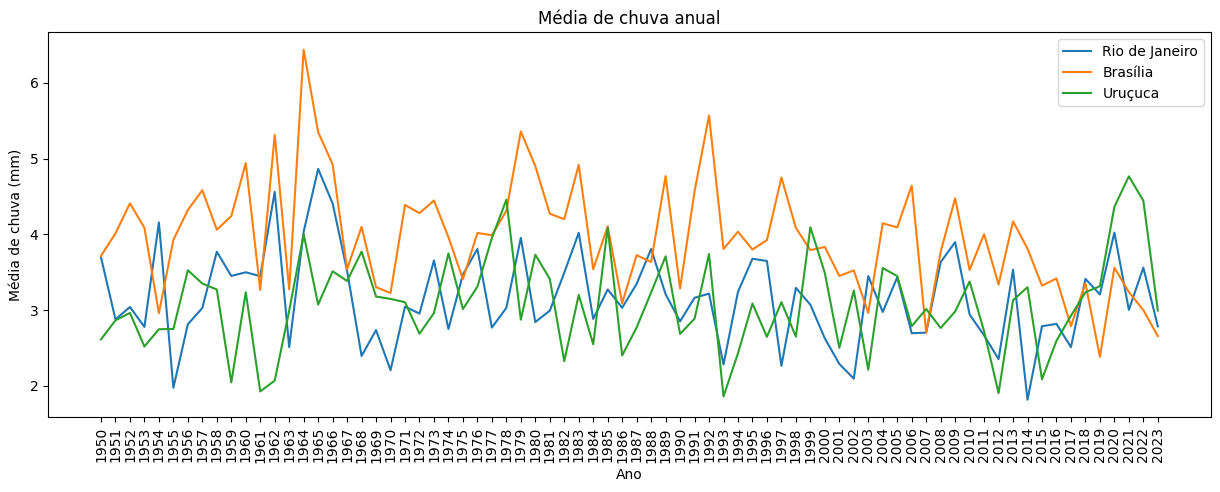

In [35]:
# criamos um gráfico mostrando os dados de 'media_chuva_uruçuca_df', 'media_chuva_uruçuca_df' e media_chuva_rio_df

plt.figure(figsize=(15, 5))
plt.plot(media_chuva_rio_df['ano'], media_chuva_rio_df['media_chuva'], label='Rio de Janeiro')
plt.plot(media_chuva_brasilia_df['ano'], media_chuva_brasilia_df['media_chuva'], label='Brasília')
plt.plot(media_chuva_uruçuca_df['ano'], media_chuva_uruçuca_df['media_chuva'], label='Uruçuca')
plt.xlabel('Ano')
plt.ylabel('Média de chuva (em mil mm)')
plt.title('Média de chuva anual')
plt.legend()
plt.xticks(rotation=90)
plt.show()
